In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

## Working in relative coordinates for particles 1 and 2:
## (This makes PN corrections easier)
### $\mathbf{a} = \mathbf{a}_1 - \mathbf{a}_2$
### $\mathbf{r} = \mathbf{r}_1 - \mathbf{r}_2=(r_x,r_y)$
### $\mathbf{n} = \mathbf{r}/r = \mathbf{n}_{12} = -\mathbf{n}_{21}$


## EOM:
### (Chapter 9 of ``Gravity: Newtonian, Post-Newtonian, Relativistic'', Poisson & Will)
\begin{equation}
\begin{split}
\mathbf{a} = \mathbf{r}''(t) = &-\frac{ G m }{r^2 (t)} \mathbf{n}(t)  \\
&-  \frac{Gm}{c^2 r^2 } \Bigg( \Big( v^2 (1+3\eta) - \frac{3}{2} (\mathbf{n} \cdot \mathbf{v})^2 \eta - 2(2+\eta) \frac{Gm}{r} \Big) \mathbf{n} \\
& \hspace{2cm}  - 2 (2-\eta) (\mathbf{n} \cdot \mathbf{v})  \mathbf{v} \Bigg) \\
& \ + \mathcal{O} \Big( \frac{1}{c^{4}} \Big)
\end{split}
\end{equation}


with: $m = M_1  + M_2$ , and  $\ \ \eta = (M_1 M_2) / (M_1  + M_2)^2$
### $r_x''(t) = a_{0} + a_{1} + a_{2} + a_{3} + a_{4}$
### $a_0(t) = -\frac{ G m }{(r_x^2 + r_y^2)^{3/2}} r_x $
### $a_1(t) = -\frac{ G m }{c^2 (r_x^2 + r_y^2)^{3/2}}r_x (v_x^2 + v_y^2) ( 1 + 3 \eta) $
### $a_2(t) = +\frac{3}{2}\frac{ G m }{c^2 (r_x^2 + r_y^2)^{5/2}}r_x (r_x v_x + r_y v_y)^2 \eta $
### $a_3(t) = +2\frac{ (G m)^2 }{c^2 (r_x^2 + r_y^2)^{4/2}}r_x ( 2 + \eta) $
### $a_4(t) = +2\frac{ G m }{c^2 (r_x^2 + r_y^2)^{3/2}}( 2 -\eta)(r_x v_x + r_y v_y) v_x$


## For Python : $y = r_x, r_y, r_x', r_y' =r_x, r_y, v_x, v_y$

In [421]:
def a0_component(r_x, r_y, Gm):
    return -Gm*r_x* ((r_x*r_x +r_y*r_y)**(-1.5))

def a1_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    v_squared = v_x*v_x +v_y*v_y
    eta_factor = 1 + 3*eta
    return -Gm*r_x* ((r_x*r_x +r_y*r_y)**(-1.5)) * v_squared * eta_factor / c_squared

def a2_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    r_dot_v = r_x*v_x +r_y*v_y
    return + 1.5 *Gm*r_x* ((r_x*r_x +r_y*r_y)**(-2.5)) * eta * r_dot_v * r_dot_v/ c_squared

def a3_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    eta_factor = 2 + eta
    return + 2 *Gm*Gm*r_x* ((r_x*r_x +r_y*r_y)**(-2.)) * eta_factor / c_squared

def a4_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    r_dot_v = r_x*v_x +r_y*v_y
    eta_factor = 2 - eta
    return + 2 *Gm*v_x* ((r_x*r_x +r_y*r_y)**(-1.5)) * eta_factor *r_dot_v/ c_squared

def total_relative_a(r_x, r_y, v_x, v_y, Gm, c_squared, eta):
    total = a0_component(r_x, r_y, Gm) + \
            a1_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta) + \
            a2_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta) + \
            a3_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta) + \
            a4_component(r_x, r_y, v_x, v_y, Gm, c_squared, eta)
    return total

def relative_dynamics(y,t,Gm, c_squared, eta):
    r_x, r_y, v_x, v_y = y
    dydt = [v_x,
            v_y,
            total_relative_a(r_x, r_y, v_x, v_y, Gm, c_squared, eta),
            total_relative_a(r_y, r_x, v_y, v_x, Gm, c_squared, eta)]
    a.append(total_relative_a(r_x, r_y, v_x, v_y, Gm, c_squared, eta))
    return dydt

In [422]:
a = []
c_squared_val = (3e8)**2.
M_1_GW150914 = 35 * 1.989e+30
M_2_GW150914 = 30 * 1.989e+30 
eta_val = (M_1_GW150914 * M_2_GW150914) / ((M_1_GW150914 +  M_2_GW150914)**2.)
print(eta_val)
Gm_val = 6.674e-11 * (M_1_GW150914 + M_2_GW150914)
t = np.linspace(0, 5, int(1e4))

0.2485207100591716


In [423]:
r_isco_tot_approx = 6 * Gm_val / c_squared_val

In [424]:
y0 = [r_isco_tot*20., 0., 0., r_isco_tot*37]

In [425]:
sol_non_rel = odeint(relative_dynamics, y0, t, args=(Gm_val, c_squared_val*1e10, eta_val*0. +1.,))
# sol = odeint(relative_dynamics, y0, t, args=(Gm_val, c_squared_val, eta_val,))

In [428]:
plt.plot(a)
plt.plot(a_newton)

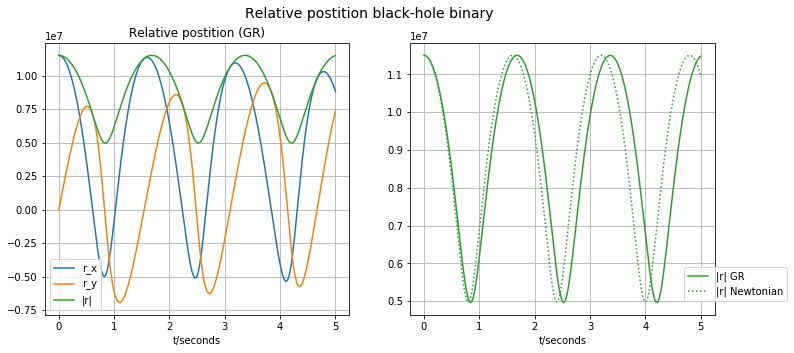

In [406]:
_ = plt.figure(figsize=(12,5)), plt.subplot(1,2,1), plt.title('Relative postition (GR)')
_ = plt.plot(t, sol[:, 0], label='r_x')
_ = plt.plot(t, sol[:, 1], label='r_y')
_ = plt.plot(t, np.sqrt(sol[:, 0]**2.+sol[:, 1]**2.), label='|r|')
_ = plt.legend(loc='best'), plt.xlabel('t/seconds'), plt.grid()
_ = plt.subplot(1,2,2)
_ = plt.plot(t, np.sqrt(sol[:, 0]**2.+sol[:, 1]**2.), label='|r| GR', c='C2')
_ = plt.plot(t, np.sqrt(sol_non_rel[:, 0]**2.+sol_non_rel[:, 1]**2.), c='C2', ls=':',label='|r| Newtonian')
_ = plt.legend(loc=(0.9,0.05)), plt.xlabel('t/seconds'), plt.grid()
_ = plt.suptitle(r'Relative postition black-hole binary', fontsize=14)
_ = plt.savefig('bh_binary_pn.png' , dpi=200)

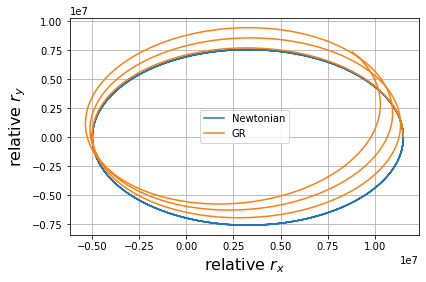

In [408]:
colors = plt.cm.inferno(np.linspace(0,1,len(t)))

_ = plt.plot(sol_non_rel[:, 0], sol_non_rel[:, 1], c='C0', label='Newtonian')
# for i in range(len(t)):
#     plt.scatter(sol[i, 0], sol[i, 1], color=colors[i], marker='.', alpha=0.3, label='GR')
#     if i==0:
#         plt.legend()
_ = plt.plot(sol[:, 0], sol[:, 1], c='C1', label='GR'), plt.legend()
_ = plt.ylabel(r'relative $r_y$', fontsize=16), plt.xlabel(r'relative $r_x$', fontsize=16), plt.grid()
_ = plt.tight_layout(True), plt.savefig('bh_binary_pn2.png' , dpi=200)